In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import hvplot.pandas
import warnings, scipy, statsmodels


In [2]:
dataset = yf.download("AAPL")

[*********************100%***********************]  1 of 1 completed


In [3]:
df = dataset[['Adj Close']]

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df.isnull().sum()

Adj Close    0
dtype: int64

In [6]:
df.hvplot.line()

:Curve   [Date]   (Adj Close)

In [7]:
decomposition = seasonal_decompose(df, model='additive',period=90)


In [8]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [9]:
# Calculate z-scores for the residuals
z_scores = (residual - residual.mean()) / residual.std()

# Define a threshold for outliers (e.g., z-score > 3 or z-score < -3)
threshold = 3

# Find the outliers
outliers = df[z_scores.abs() > threshold]

In [10]:
mean_value = residual.mean()
residual.loc[outliers.index] = mean_value

In [11]:
residual.hvplot.line()

:Curve   [Date]   (resid)

In [12]:
residual = residual.fillna(method='ffill')
residual = residual.fillna(method='bfill')

In [13]:
trend = trend.fillna(method='ffill')
trend = trend.fillna(method='bfill')

In [14]:
seasonal = seasonal.fillna(method='ffill')
seasonal = seasonal.fillna(method='bfill')

In [15]:
df = seasonal+trend+residual

In [16]:
df = pd.DataFrame(df)

In [17]:
decomposition = seasonal_decompose(df, model='additive',period=400)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [18]:
df.hvplot.line()

:Curve   [Date]   (0)

In [19]:
trend.hvplot.line()

:Curve   [Date]   (trend)

In [20]:
seasonal.hvplot.line()

:Curve   [Date]   (seasonal)

In [21]:
residual.hvplot.line()

:Curve   [Date]   (resid)

In [22]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [23]:
hpfilter(df)
cyclic, trend = hpfilter(df)

<Axes: title={'center': 'Trend Component'}, xlabel='Date'>

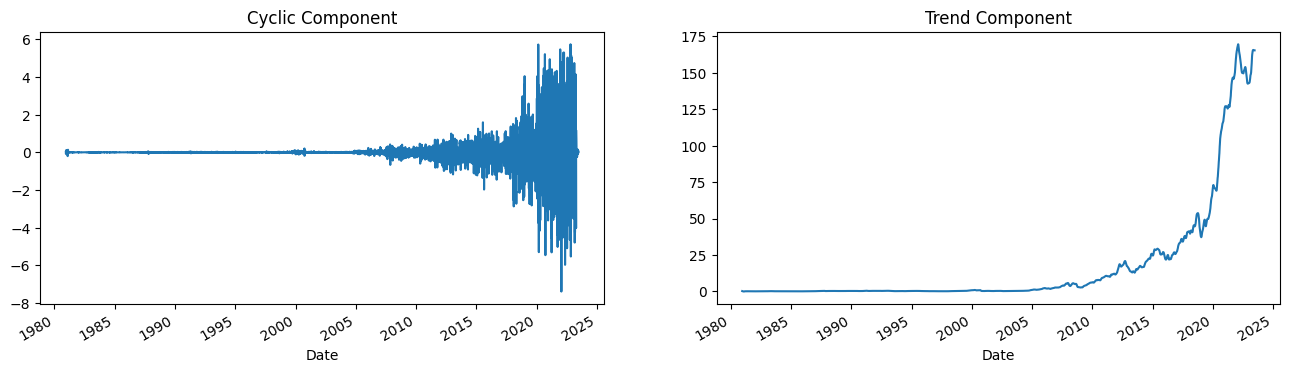

In [24]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
cyclic.plot(ax=ax[0], title='Cyclic Component')
trend.plot(ax=ax[1], title='Trend Component')

In [25]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller, kpss

In [26]:
def print_results(output, test):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

In [27]:
adf_output = adfuller(df)
kpss_output = kpss(df)

C:\Users\Shaurya\AppData\Local\Temp\ipykernel_22700\1012672925.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_output = kpss(df)


In [28]:
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

adf            kpss
Test Statistic               3.325128        8.061728
p-value                           1.0            0.01
Numbers of lags                    38              60
decision               Non-Stationary  Non-Stationary
Critical Value (1%)         -3.430962           0.739
Critical Value (5%)         -2.861811           0.463
Critical Value (10%)        -2.566914           0.347
Critical Value (2.5%)             NaN           0.574

its not stationary as:
p-value(adf)>0.05
and
p-value(kpss)<0.05

In [29]:
first_ord_diff = df.diff().dropna()

In [30]:
first_ord_diff.hvplot()

:Curve   [Date]   (0)

In [31]:
adf_output1 = adfuller(first_ord_diff)
kpss_output1 = kpss(first_ord_diff)

C:\Users\Shaurya\AppData\Local\Temp\ipykernel_22700\2961342052.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_output1 = kpss(first_ord_diff)


In [32]:
pd.concat([
print_results(adf_output1, 'adf'),
print_results(kpss_output1, 'kpss')
], axis=1)

adf            kpss
Test Statistic          -11.79667        2.480653
p-value                       0.0            0.01
Numbers of lags                37              27
decision               Stationary  Non-Stationary
Critical Value (1%)     -3.430962           0.739
Critical Value (5%)     -2.861811           0.463
Critical Value (10%)    -2.566914           0.347
Critical Value (2.5%)         NaN           0.574

In [33]:
log_transform = np.log(df)

C:\Users\Shaurya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [34]:
log_transform.hvplot.line()

:Curve   [Date]   (0)

In [35]:
log_diff = log_transform.diff().dropna()

In [36]:
log_diff.hvplot.line()

:Curve   [Date]   (0)

In [37]:
actual = log_diff[30:]

In [38]:
adf_output_ = adfuller(actual)
kpss_output_ = kpss(actual)

C:\Users\Shaurya\AppData\Local\Temp\ipykernel_22700\3986255184.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_output_ = kpss(actual)


In [39]:
pd.concat([
print_results(adf_output_, 'adf'),
print_results(kpss_output_, 'kpss')
], axis=1)

adf        kpss
Test Statistic         -26.331254    0.191976
p-value                       0.0         0.1
Numbers of lags                13           6
decision               Stationary  Stationary
Critical Value (1%)     -3.430964       0.739
Critical Value (5%)     -2.861811       0.463
Critical Value (10%)    -2.566914       0.347
Critical Value (2.5%)         NaN       0.574

we have made the time series stationary by taking its log and then using its first difference

In [40]:
from scipy.stats import shapiro

In [41]:
def is_normal(test):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [42]:
print(is_normal(shapiro(actual)))
print(is_normal(shapiro(df)))

Not Normal
Not Normal


C:\Users\Shaurya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


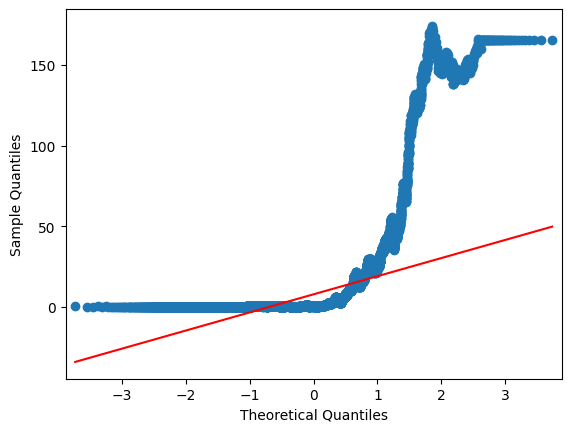

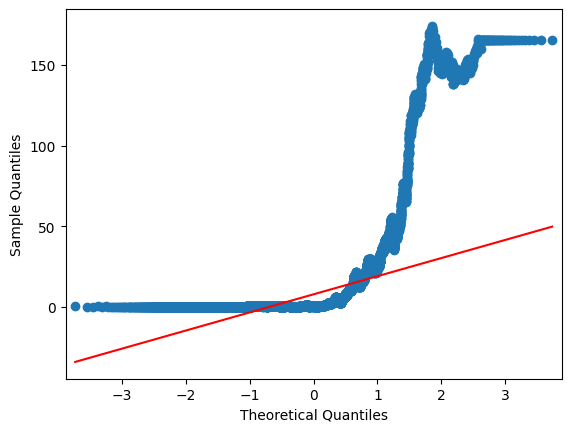

In [43]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df, line='q')

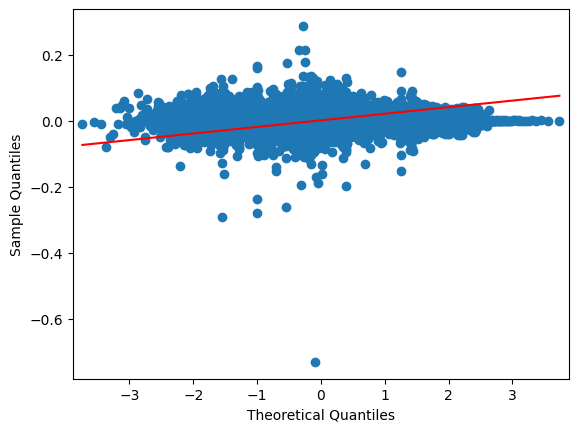

In [44]:
qqplot(actual, line='q');

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 1.400e+01,
        1.929e+03, 8.637e+03, 7.500e+01, 3.000e+00]),
 array([-0.7312478 , -0.62943381, -0.52761983, -0.42580585, -0.32399187,
        -0.22217788, -0.1203639 , -0.01854992,  0.08326406,  0.18507804,
         0.28689203]),
 <BarContainer object of 10 artists>)

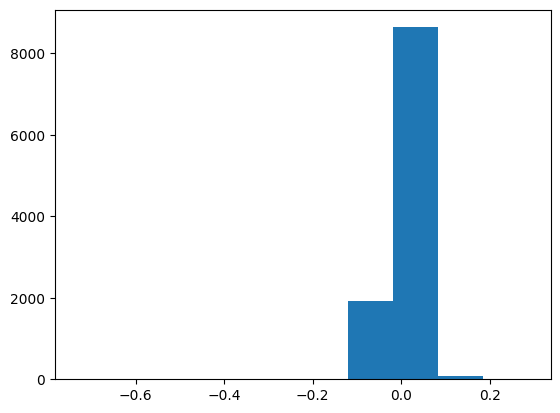

In [45]:
plt.hist(actual)

therefore it cannot be considered normally distributed

In [46]:
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_white)
from statsmodels.tools.tools import add_constant

In [47]:
actual.columns=["values"]
actual

values
Date                
1981-03-04 -0.009578
1981-03-05 -0.004819
1981-03-06 -0.009708
1981-03-09 -0.081258
1981-03-10 -0.048797
...              ...
2023-06-12  0.000723
2023-06-13 -0.000192
2023-06-14  0.000438
2023-06-15 -0.000811
2023-06-16  0.000145

[10663 rows x 1 columns]

In [48]:
df.columns=["value"]
df

value
Date                  
1980-12-12    0.250876
1980-12-15    0.145510
1980-12-16    0.116522
1980-12-17    0.236040
1980-12-18    0.204264
...                ...
2023-06-12  165.447244
2023-06-13  165.415468
2023-06-14  165.487867
2023-06-15  165.353679
2023-06-16  165.377634

[10718 rows x 1 columns]

In [49]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(df.dropna(), lags=1, trend='n').fit()

C:\Users\Shaurya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [50]:
model.fittedvalues

Date
1980-12-15      0.251026
1980-12-16      0.145597
1980-12-17      0.116591
1980-12-18      0.236181
1980-12-19      0.204385
                 ...    
2023-06-12    165.426442
2023-06-13    165.546031
2023-06-14    165.514236
2023-06-15    165.586679
2023-06-16    165.452411
Length: 10717, dtype: float64

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  value   No. Observations:                10718
Model:                     AutoReg(1)   Log Likelihood              -11814.763
Method:               Conditional MLE   S.D. of innovations              0.729
Date:                Tue, 20 Jun 2023   AIC                          23633.525
Time:                        21:53:12   BIC                          23648.085
Sample:                             1   HQIC                         23638.437
                                10718                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
value.L1       1.0006      0.000   5847.029      0.000       1.000       1.001
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9994           +0.0000j            0.9994            0.0000
-----------------------------------------------------------------------------
"""

In [52]:
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        het_breuschpagan(model.resid, 
                         add_constant(
                             model.fittedvalues)
                        ))
    
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"

In [53]:
het_test(model, test=het_breuschpagan)

'Heteroskedastic'

In [54]:
from scipy.stats import boxcox

In [55]:
df

value
Date                  
1980-12-12    0.250876
1980-12-15    0.145510
1980-12-16    0.116522
1980-12-17    0.236040
1980-12-18    0.204264
...                ...
2023-06-12  165.447244
2023-06-13  165.415468
2023-06-14  165.487867
2023-06-15  165.353679
2023-06-16  165.377634

[10718 rows x 1 columns]

In [56]:
xt, lmbda = boxcox(abs(df['value']))

In [57]:
xts = pd.Series(xt, index=df.index)

Text(0.5, 1.0, 'Box-Cox Transformed')

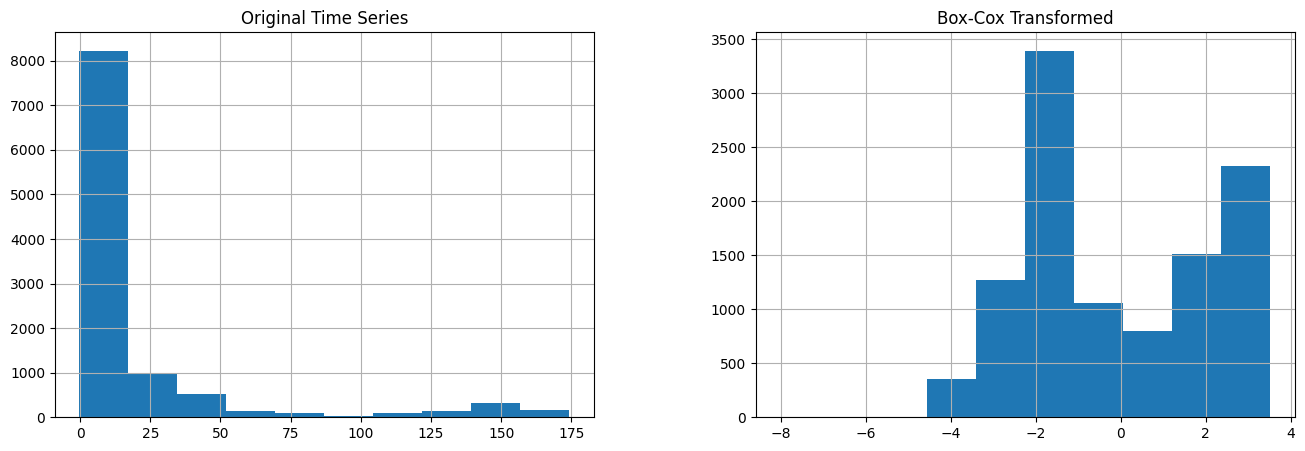

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
df.hist(ax=ax[0])
ax[0].set_title('Original Time Series')
xts.hist(ax=ax[1])
ax[1].set_title('Box-Cox Transformed')

(array([  34.,   36.,   42.,   83., 7254., 3044.,  117.,   47.,   28.,
          32.]),
 array([-6.50364458e+00, -5.20166778e+00, -3.89969098e+00, -2.59771418e+00,
        -1.29573738e+00,  6.23941799e-03,  1.30821622e+00,  2.61019302e+00,
         3.91216981e+00,  5.21414661e+00,  6.51612341e+00]),
 <BarContainer object of 10 artists>)

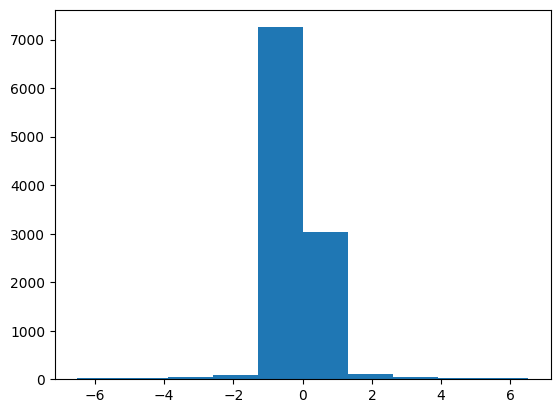

In [59]:
plt.hist(model.resid)

In [60]:
model.resid.mean()

0.005113037197118942

In [61]:
model.test_heteroskedasticity()

ARCH-LM        P-value  DF
Lag                                
1    1356.459097  6.082284e-297   1
2    1620.809536   0.000000e+00   2
3    1772.935015   0.000000e+00   3
4    1899.432657   0.000000e+00   4
5    2073.995973   0.000000e+00   5
6    2121.170958   0.000000e+00   6
7    2297.006157   0.000000e+00   7
8    2390.952606   0.000000e+00   8
9    2399.628043   0.000000e+00   9
10   2411.923935   0.000000e+00  10

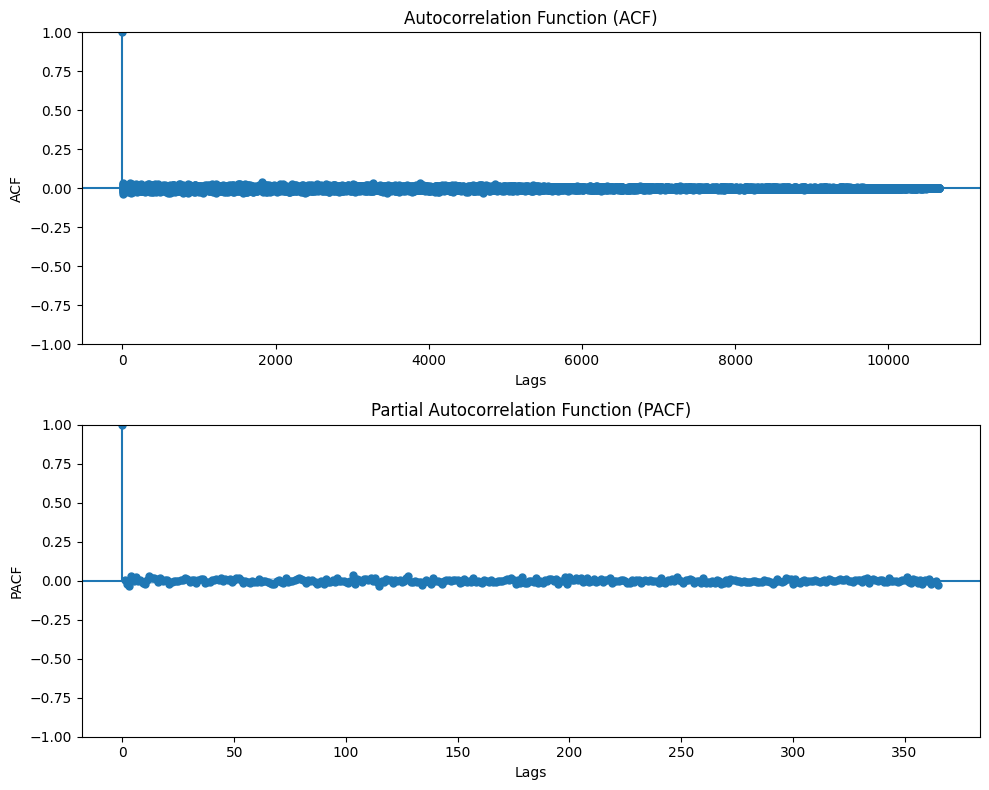

In [76]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import matplotlib.pyplot as plt


# Compute the ACF and PACF values
acf_vals = sm.tsa.stattools.acf(actual)
pacf_vals = sm.tsa.stattools.pacf(actual)

# Create subplots for the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the ACF
tsaplots.plot_acf(actual, ax=ax1, lags=len(actual)-1)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lags')
ax1.set_ylabel('ACF')

# Plot the PACF
tsaplots.plot_pacf(actual, ax=ax2, lags=365)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('PACF')

plt.tight_layout()
plt.show()
